In [1]:
import numpy as np
import pandas as pd
import time
import os

In [2]:
def loadNLPVectors(filename):
    file = 'nlp_data/' + filename + '.npy'
    return np.load(file)

In [3]:
def loadLabels():
    return loadNLPVectors("labels")

In [4]:
from sklearn.model_selection import train_test_split
def genData(nlp):
    X_train, X_test, y_train, y_test = train_test_split(nlp, labels,
                                                        test_size = 0.2,
                                                        random_state = 42,
                                                        shuffle = True,
                                                        stratify = labels)
    
    train = [X_train, y_train]
    test = [X_test, y_test]
    
    return train, test

# Load NLP Data

In [5]:
unigram_array = "feature_array_unigram"
bigram_array = "feature_array_bigram"
tfidf_array = "feature_array_tfidf"
wordvec_array = "feature_array_word2vec"
unigram_reduced = "reduced_unigram"
bigram_reduced = "reduced_bigram"
tfidf_reduced = "reduced_tfidf"

In [6]:
unigram = loadNLPVectors(unigram_array)
bigram = loadNLPVectors(bigram_array)
tfidf = loadNLPVectors(tfidf_array)
word2vec = loadNLPVectors(wordvec_array)
reduced_unigram = loadNLPVectors(unigram_reduced)
reduced_bigram = loadNLPVectors(bigram_reduced)
reduced_tfidf = loadNLPVectors(tfidf_reduced)
labels = loadLabels()

# Generate Training and Testing Data

In [7]:
train_uni, test_uni = genData(unigram)

In [8]:
train_big, test_big = genData(bigram)

In [9]:
train_tfidf, test_tfidf = genData(tfidf)

In [10]:
train_vec, test_vec = genData(word2vec)

In [11]:
train_runi, test_runi = genData(reduced_unigram)

In [12]:
train_rbig, test_rbig = genData(reduced_bigram)

In [13]:
train_rtfidf, test_rtfidf = genData(reduced_tfidf)

# Keras - Neural Networks

In [5]:
from tensorflow.keras import models
from tensorflow.keras import layers

Limited tf.compat.v2.summary API due to missing TensorBoard installation
Limited tf.summary API due to missing TensorBoard installation


In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [7]:
def plotFigures(hist, epoch_range):
    
    validation_loss = hist.history['val_loss']
    validation_acc = hist.history['val_accuracy']
    
    epochs = range(1, epoch_range + 1)
    
    f = plt.figure(1)
    plt.title("Loss")
    plt.plot(epochs, validation_loss, 'bo')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    
    g = plt.figure(2)
    plt.title("Accuracy")
    plt.plot(epochs, validation_acc, 'ro')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
    
    plt.show()

In [8]:
def evaluate(model, history, test, epoch_range, nn_name, model_name):
    X_test = test[0]
    y_test = test[1]
    
    pred_sigmoid = model.predict(X_test)
    pred = []
    for p in pred_sigmoid:
        if p < .5:
            pred.append(0)
        else:
            pred.append(1)
    y_pred = np.asarray(pred)
    
    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    f = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    print(nn_name + ' ' + model_name + ' Evaluation: ')
    print('Accuracy:       ', acc)
    print('ROC AUC Score:  ', roc_auc)
    print('F1 Score:       ', f)
    print('Precision:      ', precision)
    print('Recall:         ', recall)
    
    plotFigures(history, epoch_range)

# Generate Sequential Neural Network

In [9]:
def DNN(train, test, iterations = 10):
    X_train = train[0]
    y_train = train[1]
    
    X_test = test[0]
    y_test = test[1]
    
    #~13000, ~80000, 500, 200, 50
    dim = len(X_train[0])
    
    model = models.Sequential()
    if dim > 15000:
        model.add(layers.Dense(500, activation = 'relu', input_shape = (dim,)))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(64, activation = 'relu'))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(4, activation = 'relu'))
    elif dim > 10000:
        model.add(layers.Dense(200, activation = 'relu', input_shape = (dim,)))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(32, activation = 'relu'))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(4, activation = 'relu'))
    elif dim == 500:
        model.add(layers.Dense(64, activation = 'relu', input_shape = (dim,)))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(16, activation = 'relu'))
    elif dim == 200:
        model.add(layers.Dense(32, activation = 'relu', input_shape = (dim,)))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(4, activation = 'relu'))
    elif dim == 50:
        model.add(layers.Dense(16, activation = 'relu', input_shape = (dim,)))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(4, activation = 'relu', input_shape = (dim, )))
    model.add(layers.Dense(1, activation = 'sigmoid'))
    
    model.summary()
    model.compile(loss = 'binary_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy'])
    
    start = time.time()
    history = model.fit(X_train, y_train,
                        epochs = iterations,
                        batch_size = 128,
                        validation_data = (X_test, y_test))
    end = time.time() - start
    
    test = model.evaluate(X_test, y_test)
    
    print("Training Time:  ", end)
    print("Model Loss:     ", test[0])
    print("Model Accuracy: ", test[1])
    
    return model, history

# Generate Convolutional Neural Network

In [26]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [27]:
def loadCSV(filename):
    file = filename
    if '.csv' not in filename:
        file += '.csv'
    data = pd.read_csv(file, encoding = 'ISO-8859-1')
    return data

In [30]:
data = loadCSV("binary_classification")
tokenizer = Tokenizer()

In [31]:
X = [x for x in data["tweet_text"]]
tokenizer.fit_on_texts(X)

In [36]:
train_sequences = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index
print("%s Unique Tokens" % len(word_index))

13396 Unique Tokens


In [38]:
max_input_len = max([len(x) for x in X])
print("Max Sequence Length: %s" % max_input_len)

Max Sequence Length: 129


In [ ]:
X_padded = []

In [19]:
def CNN(train, test, iterations = 10):
    return

# Generate Recurrent Neural Network

In [20]:
def RNN(train, test, iterations = 10):
    return

# Training Deep Neural Networks

### DNN Reduced Unigram

In [21]:
epoch_runi = 50
dnn_runi, dnn_runi_history = DNN(train_runi, test_runi, epoch_runi)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                6432      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 132       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 6,569
Trainable params: 6,569
Non-trainable params: 0
_________________________________________________________________
Train on 10404 samples, validate on 2601 samples
Epoch 1/50
10404/10404 [==============================] - 1s 76us/sample - loss: 0.6722 - accuracy: 0.6139 - val_loss: 0.6359 - val_accuracy: 0.7470
Epoch 2/50
10404/10404 [==============================

### DNN Reduced Bigram

In [22]:
epoch_rbig = 20
dnn_rbig, dnn_rbig_history = DNN(train_rbig, test_rbig, epoch_rbig)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                32064     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 33,121
Trainable params: 33,121
Non-trainable params: 0
_________________________________________________________________
Train on 10404 samples, validate on 2601 samples
Epoch 1/20
10404/10404 [==============================] - 1s 69us/sample - loss: 0.6283 - accuracy: 0.6994 - val_loss: 0.4925 - val_accuracy: 0.8654
Epoch 2/20
10404/10404 [==========================

### DNN Reduced TFIDF

In [23]:
epoch_rtfidf = 50
dnn_rtfidf, dnn_rtfidf_history = DNN(train_rtfidf, test_rtfidf, epoch_rtfidf)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                6432      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 132       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 5         
Total params: 6,569
Trainable params: 6,569
Non-trainable params: 0
_________________________________________________________________
Train on 10404 samples, validate on 2601 samples
Epoch 1/50
10404/10404 [==============================] - 1s 55us/sample - loss: 0.6820 - accuracy: 0.5705 - val_loss: 0.6554 - val_accuracy: 0.7140
Epoch 2/50
10404/10404 [============================

### DNN Word2Vec

In [24]:
epoch_vec = 50
dnn_vec, dnn_vec_history = DNN(train_vec, test_vec, epoch_vec)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 16)                816       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 68        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 5         
Total params: 889
Trainable params: 889
Non-trainable params: 0
_________________________________________________________________
Train on 10404 samples, validate on 2601 samples
Epoch 1/50
10404/10404 [==============================] - 1s 68us/sample - loss: 0.6930 - accuracy: 0.5126 - val_loss: 0.6929 - val_accuracy: 0.5129
Epoch 2/50
10404/10404 [==============================] 

### DNN Unigram

In [25]:
epoch_uni = 50
dnn_uni, dnn_uni_history = DNN(train_uni, test_uni, epoch_uni)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 200)               2676600   
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                6432      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 132       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 5         
Total params: 2,683,169
Trainable params: 2,683,169
Non-trainable params: 0
____________________________________________

### DNN Bigram

In [26]:
epoch_big = 50
dnn_big, dnn_big_history = DNN(train_big, test_big, epoch_big)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 500)               39907000  
_________________________________________________________________
dropout_6 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)                32064     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 4)                 260       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 5         
Total params: 39,939,329
Trainable params: 39,939,329
Non-trainable params: 0
__________________________________________

### DNN TFIDF

In [27]:
epoch_tfidf = 50
dnn_tfidf, dnn_tfidf_history = DNN(train_tfidf, test_tfidf, epoch_tfidf)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 200)               2676600   
_________________________________________________________________
dropout_8 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 32)                6432      
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 4)                 132       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 5         
Total params: 2,683,169
Trainable params: 2,683,169
Non-trainable params: 0
____________________________________________

## Evaluating Deep Neural Networks

DNN Unigram Evaluation: 
Accuracy:        0.8888888888888888
ROC AUC Score:   0.8886664599823213
F1 Score:        0.8852719333068679
Precision:       0.8905750798722045
Recall:          0.8800315706393055


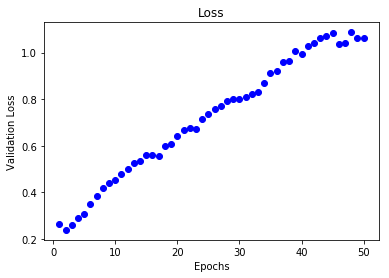

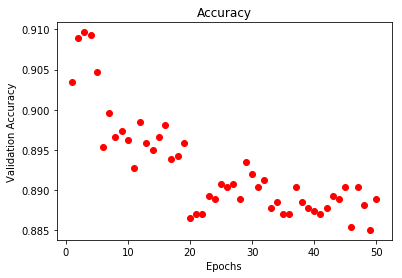

In [28]:
evaluate(dnn_uni, dnn_uni_history, test_uni, epoch_uni, 'DNN', 'Unigram')

DNN Bigram Evaluation: 
Accuracy:        0.8804306036139946
ROC AUC Score:   0.8794295630401059
F1 Score:        0.8725931995083982
Precision:       0.9071550255536627
Recall:          0.840568271507498


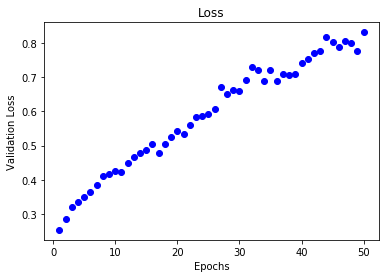

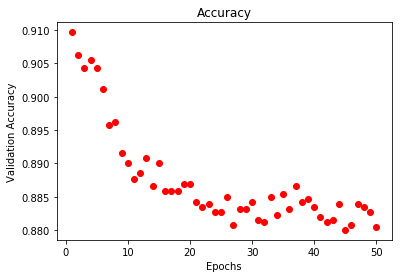

In [29]:
evaluate(dnn_big, dnn_big_history, test_big, epoch_big, 'DNN', 'Bigram')

DNN TFIDF Evaluation: 
Accuracy:        0.8589004229142637
ROC AUC Score:   0.8598869468186191
F1 Score:        0.8611426409383277
Precision:       0.8270348837209303
Recall:          0.8981846882399369


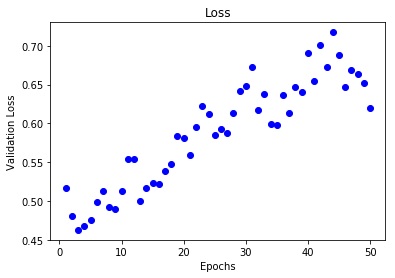

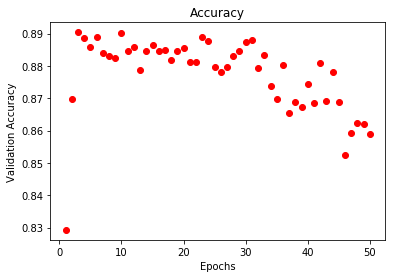

In [30]:
evaluate(dnn_tfidf, dnn_tfidf_history, test_tfidf, epoch_tfidf, 'DNN', 'TFIDF')

DNN Reduced Unigram Evaluation: 
Accuracy:        0.9146482122260668
ROC AUC Score:   0.9136401609771279
F1 Score:        0.9089417555373256
Precision:       0.946199829205807
Recall:          0.8745067087608525


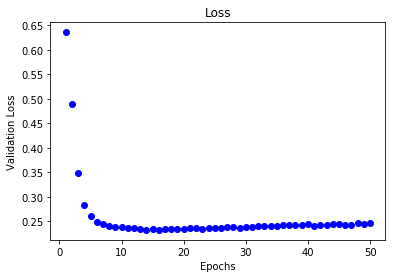

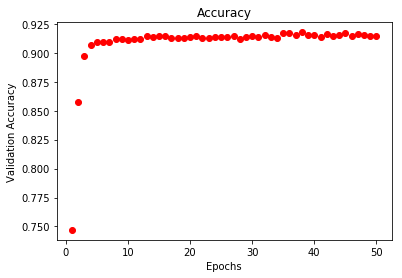

In [31]:
evaluate(dnn_runi, dnn_runi_history, test_runi, epoch_runi, 'DNN', 'Reduced Unigram')

DNN Reduced Bigram Evaluation: 
Accuracy:        0.9104190695886197
ROC AUC Score:   0.9095965040368528
F1 Score:        0.9051689051689051
Precision:       0.934453781512605
Recall:          0.877663772691397


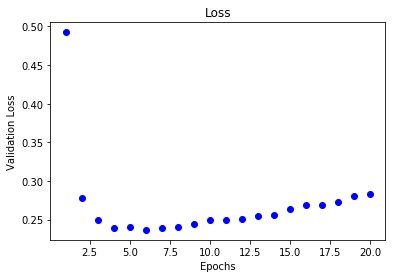

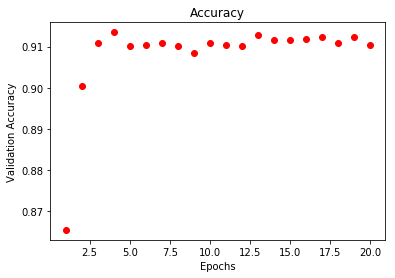

In [32]:
evaluate(dnn_rbig, dnn_rbig_history, test_rbig, epoch_rbig, 'DNN', 'Reduced Bigram')

DNN Reduced TFIDF Evaluation: 
Accuracy:        0.9161860822760477
ROC AUC Score:   0.9151592317495554
F1 Score:        0.9105090311986863
Precision:       0.9486740804106074
Recall:          0.8752959747434885


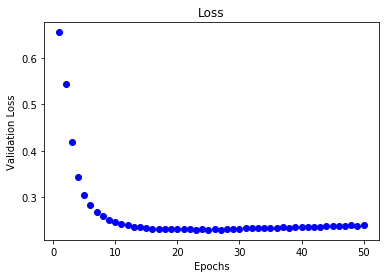

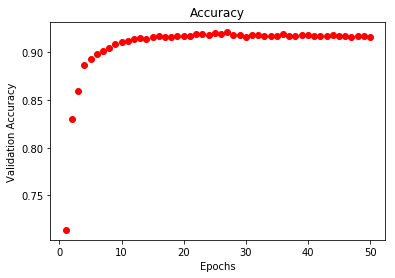

In [33]:
evaluate(dnn_rtfidf, dnn_rtfidf_history, test_rtfidf, epoch_rtfidf, 'DNN', 'Reduced TFIDF')

DNN Word2Vec Evaluation: 
Accuracy:        0.49211841599384853
ROC AUC Score:   0.48677654069571374
F1 Score:        0.34894036471168066
Precision:       0.4645669291338583
Recall:          0.27940015785319655


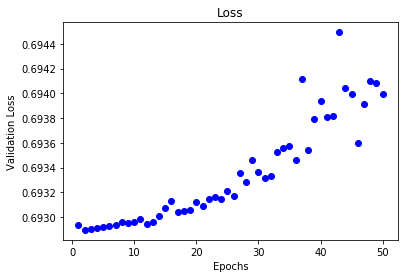

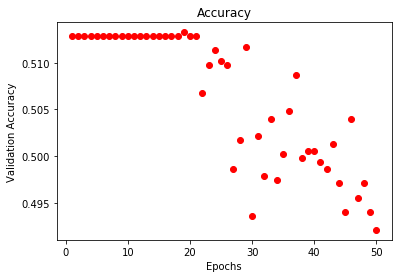

In [34]:
evaluate(dnn_vec, dnn_vec_history, test_vec, epoch_vec, 'DNN', 'Word2Vec')

# Training and Evaluating Convolutional Neural Networks

### CNN Reduced Unigram

### CNN Reduced Bigram

### CNN Reduced TFIDF

### CNN Unigram

### CNN Bigram

### CNN TFIDF

# Training and Evaluating Recurrent Neural Networks

### RNN Reduced Unigram

### RNN Reduced Bigram

### RNN Reduced TFIDF

### RNN Word2Vec

### RNN Unigram

### RNN Bigram

### RNN TFIDF